In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

/tmp/ipykernel_223/2377440119.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv", \
                    header=0, usecols=['age', 'bmi', 'children', 'charges'])
data

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


In [3]:
# Standardize Predictors
data['bmi'] = (data['bmi'] - data['bmi'].mean()) / data['bmi'].std()
data['age'] = (data['age'] - data['age'].mean()) / data['age'].std()
data['children'] = (data['children'] - data['children'].mean()) / data['children'].std()
data['charges'] = (data['charges'] - data['charges'].mean()) / data['charges'].std()
data


,age,bmi,children,charges
0,-1.438227,-0.453151,-0.908274,0.298472
1,-1.509401,0.509431,-0.078738,-0.953333
2,-0.797655,0.383164,1.580335,-0.728402
3,-0.441782,-1.305043,-0.908274,0.719574
4,-0.512957,-0.292447,-0.908274,-0.776512
...,...,...,...,...
1333,0.768185,0.050278,1.580335,-0.220468
1334,-1.509401,0.206062,-0.908274,-0.913661
1335,-1.509401,1.014499,-0.908274,-0.961237
1336,-1.295877,-0.797515,-0.908274,-0.930014


In [4]:
# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [5]:
# Prepare data for Stan
N_train = len(train_data)
x_train = np.column_stack((train_data['bmi'], train_data['age'], train_data['children']))
y_train = train_data['charges'].to_numpy()
K = x_train.shape[1]

stan_data = {
    'N': N_train,
    'K': K,
    'x': x_train,
    'y': y_train,
    'tau_0': 1,
    'tau_1': 1,
    'sigma_alpha': 5,
    'sigma_beta': np.array([5, 5, 5])
}

In [6]:
vectorized_program_code = """
data {
    int<lower=0> N;         
    int<lower=1> K;
    matrix[N, K] x;
    vector[N] y;
    
    real<lower=0> tau_0; 
    real<lower=0> tau_1; 
    real<lower=0> sigma_alpha; 
    vector<lower=0>[K] sigma_beta;        
}

parameters {
    real alpha; 
    vector[K] beta; 
    real<lower=0> sigma2; 
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors
    sigma2 ~ inv_gamma(tau_0, tau_1);
    alpha ~ normal(0, sigma_alpha);
    beta ~ multi_normal(rep_vector(0, K), diag_matrix(sigma_beta));
    
    // Likelihood
    y ~ normal(alpha + x*beta, sigma);
}
"""

In [7]:
vectorized_posterior = stan.build(vectorized_program_code, data=stan_data, random_seed=42)

fit_vectorized = vectorized_posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%


Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling:  80% (9600/12000)
Sampling:  82% (9900/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.000224 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000227 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.27 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_wfm72l7l/model_zmdsbx6u.stan', line 32, column 4 to column 38)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning oc

In [8]:
summary = az.summary(fit_vectorized)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.005,0.029,-0.050,0.057,0.0,0.0,11027.0,6215.0,1.0
beta[0],0.167,0.029,0.111,0.221,0.0,0.0,8990.0,5823.0,1.0
beta[1],0.256,0.029,0.204,0.313,0.0,0.0,9670.0,6584.0,1.0
beta[2],0.056,0.028,0.004,0.109,0.0,0.0,9884.0,6085.0,1.0
sigma2,0.881,0.038,0.808,0.952,0.0,0.0,9773.0,6525.0,1.0
sigma,0.939,0.020,0.901,0.977,0.0,0.0,9773.0,6525.0,1.0


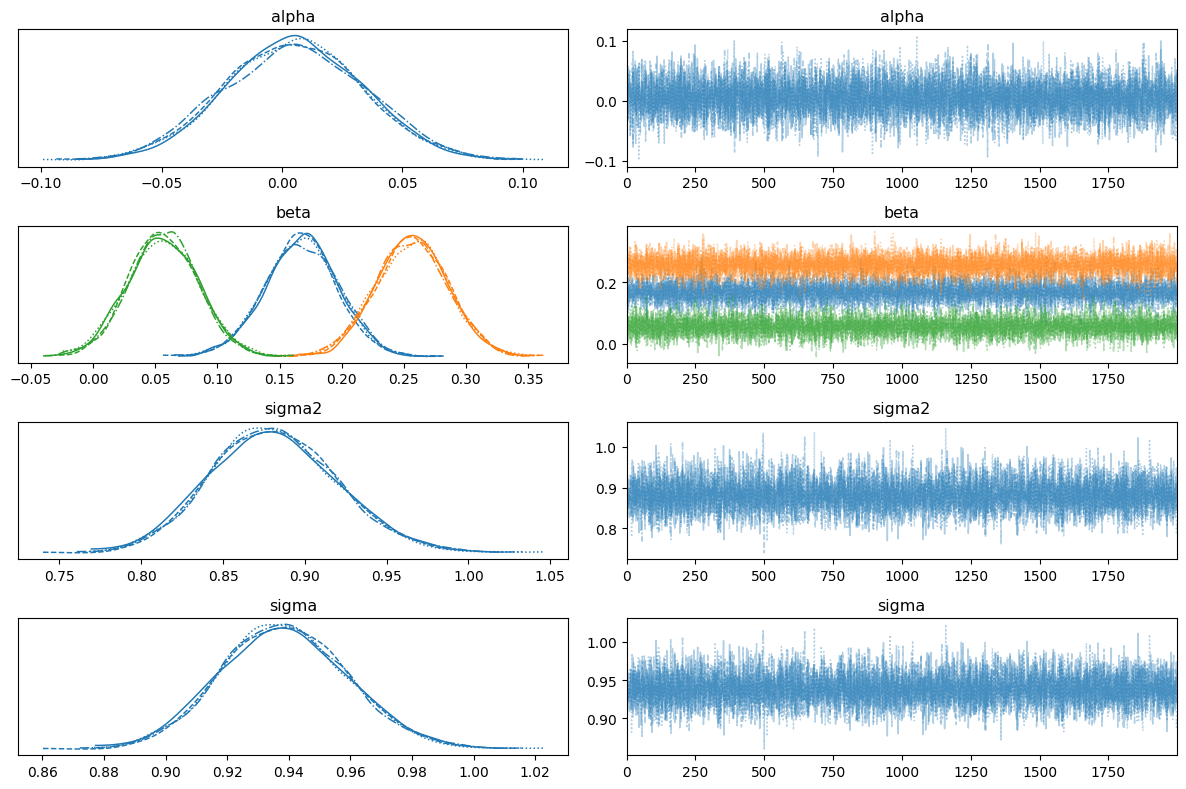

In [9]:
# Traceplots and marginals - visual convergence checks
axarr = az.plot_trace(fit_vectorized)
plt.tight_layout()

#### Which of the three variables is the best predictor of Insurance Charges?
Of the three beta values, used to represent the regression coefficients, the best one will have the highest mean and lowest standard deviation. These values are used to measure the best predictor because the higher the mean the more the fitted variable is explaining the variance in the data and the lowest standard deviation the more confidence the fitted variable has in it's value. Based on these measures, the best predictor of Insurace Charges for our dataset is beta[1] or __age__.